# Starter Code

In [7]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


################################ BEGIN NUMPY STARTER CODE #################################################
def sigmoid(x):
    #Numerically stable sigmoid function.
    #Taken from: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = np.exp(x)
        return z / (1 + z)


def sample_logistic_distribution(x,a):
    #np.random.seed(1)
    num_samples = len(x)
    y = np.empty(num_samples)
    for i in range(num_samples):
        y[i] = np.random.binomial(1,logistic_positive_prob(x[i],a))
    return y

def create_input_values(dim,num_samples):
    #np.random.seed(100)
    x_inputs = []
    for i in range(num_samples):
        x = 10*np.random.rand(dim)-5
        x_inputs.append(x)
    return x_inputs


def create_dataset():
    x= create_input_values(2,100)
    a=np.array([12,12])
    y=sample_logistic_distribution(x,a)

    return x,y

################################ END NUMPY STARTER CODE ####################################################



################################ BEGIN PYTORCH STARTER CODE ################################################

class TorchLogisticClassifier(nn.Module):

  def __init__(self, num_features):
    super().__init__()
    self.weights = nn.Parameter(torch.zeros(num_features))

  def forward(self, x_vector):
    logit = torch.dot(self.weights, x_vector)
    prob = torch.sigmoid(logit)
    return prob


def loss_fn(y_predicted, y_observed):
    return -1 * (y_observed * torch.log(y_predicted)
                 + (1 - y_observed) * torch.log(1 - y_predicted))

def extract_num_features(dataset):
    first_example = dataset[0]
    # first_example is a pair (x,y), where x is a vector of features and y is 0 or 1
    # note that both x and y are torch tensors
    first_example_x = first_example[0]
    first_example_y = first_example[1]
    num_features = first_example_x.size(0)
    return num_features

def nonbatched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01):
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(num_epochs):
        for d_x, d_y in dataset:
            optimizer.zero_grad()
            prediction = model(d_x)
            loss = loss_fn(prediction, d_y)
            loss.backward()
            optimizer.step()
    return model

def generate_nonbatched_data(num_features=3, num_examples=100):
    x_vectors = [torch.randn(num_features) for _ in range(num_examples)]
    prob_val = 0.5 * torch.ones(1)
    y_vectors = [torch.bernoulli(prob_val) for _ in range(num_examples)]

    dataset = list(zip(x_vectors, y_vectors))

    return dataset

def main():
    nonbatched_dataset = generate_nonbatched_data()
    nonbatched_gradient_descent(nonbatched_dataset)

################################ END PYTORCH STARTER CODE ###################################################


# NOTICE: DO NOT EDIT FUNCTION SIGNATURES 
# PLEASE FILL IN FREE RESPONSE AND CODE IN THE PROVIDED SPACES


# Problems 1 - 6

In [2]:
# PROBLEM 1
def logistic_positive_prob(x,a):
    z = np.dot(a, x)
    return sigmoid(z)

# PROBLEM 2
def logistic_derivative_per_datapoint(y_i,x_i,a,j):
    prob = logistic_positive_prob(x_i, a)
    return -(y_i - prob) * x_i[j]

# PROBLEM 3
def logistic_partial_derivative(y,x,a,j):
    n = len(y)
    partial_derivative = 0
    for i in range(n):
        partial_derivative += logistic_derivative_per_datapoint(y[i], x[i], a, j)
    return partial_derivative / n

# PROBLEM 4
def compute_logistic_gradient(a,y,x):
    k = len(a)
    gradient = np.zeros(k)
    for j in range(k):
        gradient[j] = logistic_partial_derivative(y, x, a, j)
    return gradient

# PROBLEM 5
def gradient_update(a,lr,gradient):
    return a - lr * gradient

# PROBLEM 6 (LUKE UPDATE)
def gradient_descent_logistic(initial_a, lr, num_iterations, y, x):
    a = initial_a
    for _ in range(num_iterations):
        gradient = compute_logistic_gradient(a, y, x)
        a = gradient_update(a, lr, gradient)
    return a


# Testing 1 - 6 

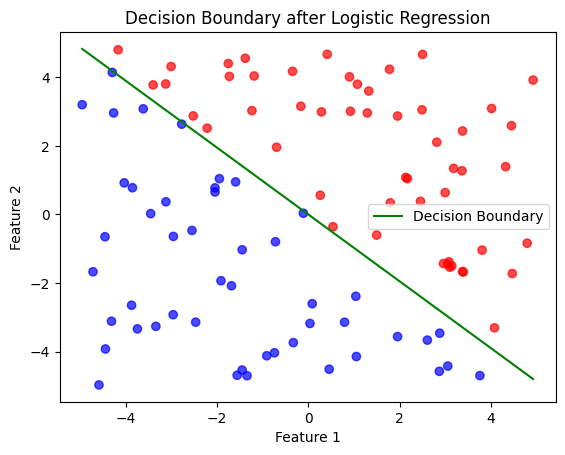

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def create_test_data():
    x, y = create_dataset()  # use the starter code to create dataset
    x = np.array(x)
    y = np.array(y)
    return x, y

def plot_decision_boundary(a, x, y):
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.7)
    x_boundary = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    y_boundary = -(a[0] / a[1]) * x_boundary
    plt.plot(x_boundary, y_boundary, color='green', label='Decision Boundary')
    plt.title('Decision Boundary after Logistic Regression')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Running a test
x, y = create_test_data()
initial_a = np.zeros(2)
lr = 0.01
num_iterations = 1000

final_a = gradient_descent_logistic(initial_a, lr, num_iterations, y, x)
plot_decision_boundary(final_a, x, y)

# Testing 9 

### Luke Code

In [16]:
def batched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01, batch_size=2):
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        batches = split_into_batches(dataset, batch_size)
        for batch in batches:
            optimizer.zero_grad()
            batch_loss = 0
            for d_x, d_y in batch:
                prediction = model(d_x)
                loss = loss_fn(prediction, d_y)
                loss.backward()
                batch_loss += loss.item()
            optimizer.step()
    return model

# PROBLEMS 10-12
def split_into_batches(dataset, batch_size):
    return [dataset[i:i + batch_size] for i in range(0, len(dataset), batch_size)]

## Graph for 9

In [45]:
def test_batched_gradient_descent():
    # Generate dataset
    dataset = generate_nonbatched_data(num_features=2, num_examples=100)
    
    # Run batched gradient descent
    model = batched_gradient_descent(dataset)
    
    # Plot the decision boundary
    a = model.weights.detach().numpy()
    x = torch.stack([d[0] for d in dataset]).numpy()
    y = torch.stack([d[1] for d in dataset]).numpy()
    plot_decision_boundary(a, x, y)

In [18]:
# Running a test
x, y = create_test_data()
dataset = (x, y)
model = batched_gradient_descent(dataset)

weights = model.weights.detach().numpy().flatten()
plot_decision_boundary(weights, x, y)

TypeError: 'int' object is not callable

10/25 new version and test

In [11]:
# def split_into_batches(dataset, batch_size):
#     x, y = dataset
#     batches = []
#     for i in range(0, len(x), batch_size):
#         x_batch = x[i:i + batch_size]
#         y_batch = y[i:i + batch_size]
#         batches.append((torch.tensor(x_batch, dtype=torch.float32), 
#                         torch.tensor(y_batch, dtype=torch.float32)))
#     return batches

# def extract_num_features(dataset):
#     x, _ = dataset
#     return x.shape[1]

# def create_test_data():
#     x, y = create_dataset()  # Replace with your dataset generation code
#     x = np.array(x)
#     y = np.array(y)
#     return x, y

# def plot_decision_boundary(a, x, y):
#     plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.7)
#     x_boundary = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
#     y_boundary = -(a[0] / a[1]) * x_boundary
#     plt.plot(x_boundary, y_boundary, color='green', label='Decision Boundary')
#     plt.title('Decision Boundary after Logistic Regression')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.legend()
#     plt.show()

def batched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01, batch_size=2):
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    batches = split_into_batches(dataset, batch_size)
    
    for _ in range(num_epochs):
        for batch in batches:
            optimizer.zero_grad()
            batch_loss = 0
            for d_x, d_y in zip(batch[0], batch[1]):
                prediction = model(d_x)
                batch_loss += loss_fn(prediction, d_y.view(-1, 1))
            batch_loss.backward()
            optimizer.step()
    
    return model

# Running a test
x, y = create_test_data()
dataset = (x, y)
model = batched_gradient_descent(dataset)

weights = model.weights.detach().numpy().flatten()
plot_decision_boundary(weights, x, y)

TypeError: 'int' object is not callable

### Gloria Code

In [51]:
def batched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01, batch_size=2):
    batches = split_into_batches(dataset, batch_size)
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(num_epochs):         # epoch loop
        for batch in batches:           # batch loop
            # only call backward once per batch per epoch
            optimizer.zero_grad()
            for d_x, d_y in batch:      # loop inside batch
                prediction = model(d_x)
                loss = loss_fn(prediction, d_y)
                loss.backward()
            optimizer.step()
    return model

# PROBLEMS 10-12
def split_into_batches(dataset, batch_size):
    k_batches = len(dataset) / batch_size
    batches = []
    i = 0
    for k in range(int(k_batches)):
        batches.append(dataset[i:i+batch_size])
        i += batch_size
    return batches

^ after restarting and trying to understand the start code i think this is the most correct

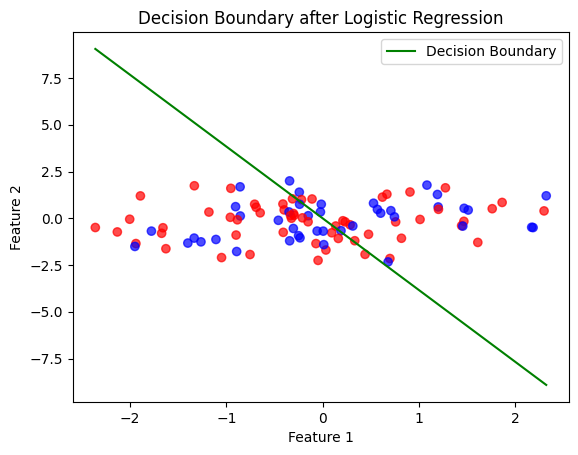

In [52]:
# this uses generate_nonbatched_data()
test_batched_gradient_descent()

In [54]:
# a different test method
# uses a clearly separable dataset, which is generated using create_dataset()
# so split_into_batches() is also different

def batched_gradient_descent(dataset, num_epochs=10, learning_rate=0.01, batch_size=2):
    batches = split_into_batches(dataset, batch_size)
    num_features = extract_num_features(dataset)
    model = TorchLogisticClassifier(num_features)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(num_epochs):         # epoch loop
        for batch in batches:           # batch loop
            # only call backward once per batch per epoch
            optimizer.zero_grad()
            for d_x, d_y in batch:      # loop inside batch
                prediction = model(d_x)
                loss = loss_fn(prediction, d_y)
                loss.backward()
            optimizer.step()
    return model

def split_into_batches(dataset, batch_size):
    num_d = len(dataset[0])
    x, y = dataset
    zipped_data = list(zip(x, y))
    k_batches = num_d / batch_size
    batches = []
    i = 0
    for k in range(int(k_batches)):
        batches.append(zipped_data[i:i+batch_size])
        i += batch_size
    return batches

x, y = create_test_data()
dataset = (x, y)
model = batched_gradient_descent(dataset)

# still not a runnable test because of tensor type in extract_num_features()
# see Luke's 10/25 new version and test

weights = model.weights.detach().numpy().flatten()
plot_decision_boundary(weights, x, y)

TypeError: 'int' object is not callable

# Restart Problem 9

Gloria 

Tyring to understand what `create_dataset()` does


In [24]:
ex_dataset = create_dataset()
ex_dataset

([array([-2.05169634, -2.51758563]),
  array([4.20951341, 4.15336279]),
  array([ 4.29233727, -3.29268858]),
  array([-3.85617005, -4.29646474]),
  array([ 1.54223062, -3.69155697]),
  array([ 2.6815849 , -0.88692678]),
  array([-2.04320931,  2.27171493]),
  array([ 2.72696634, -1.97146443]),
  array([2.71025715, 0.74492776]),
  array([-2.383074  , -3.68050611]),
  array([ 2.21456062, -2.6749133 ]),
  array([-0.94341758, -0.4881122 ]),
  array([-1.91775033,  2.70985862]),
  array([2.08994509, 2.53399731]),
  array([1.86899148, 1.28807649]),
  array([-1.6604434 , -1.29186552]),
  array([-2.35366867, -0.82519106]),
  array([1.73194408, 4.70363766]),
  array([4.86250207, 4.53772845]),
  array([1.92814345, 3.44852974]),
  array([-0.02724199,  2.39365067]),
  array([ 2.4523428 , -4.94696918]),
  array([-4.1247445 ,  4.22229613]),
  array([-2.97703689,  4.33166088]),
  array([-4.50498638, -3.33003929]),
  array([4.7398735 , 0.22847311]),
  array([-2.86489692, -2.72809955]),
  array([ 3.41328

In [26]:
len(ex_dataset)

2

In [27]:
len(ex_dataset[0])

100

The function outputs a dataset of 100 points. The output format is a tuple (x,y), each of length 100.

Now trying to understanding what `generate_nonbatched_data()` does

In [37]:
generate_nonbatched_data()

[(tensor([-0.5939,  1.1233,  1.8531]), tensor([0.])),
 (tensor([ 0.7341,  0.4655, -0.0280]), tensor([0.])),
 (tensor([ 0.4364, -2.3818, -1.0300]), tensor([1.])),
 (tensor([ 0.2062, -0.2134, -1.2126]), tensor([0.])),
 (tensor([-0.2113,  0.8279, -0.7842]), tensor([1.])),
 (tensor([ 0.4209,  0.5139, -0.7569]), tensor([1.])),
 (tensor([-0.7143,  1.1771,  0.1155]), tensor([1.])),
 (tensor([0.8745, 1.1663, 0.1936]), tensor([0.])),
 (tensor([ 1.1355,  0.2191, -0.9418]), tensor([1.])),
 (tensor([0.9344, 1.0113, 0.4482]), tensor([0.])),
 (tensor([-1.4086,  2.3455,  0.0729]), tensor([0.])),
 (tensor([ 0.3178, -0.7509, -2.3187]), tensor([1.])),
 (tensor([-1.4464,  0.9811,  0.1185]), tensor([1.])),
 (tensor([ 1.5596, -1.5853, -0.3779]), tensor([0.])),
 (tensor([-0.6862, -0.7388,  0.4241]), tensor([0.])),
 (tensor([1.5758, 0.5534, 0.6185]), tensor([0.])),
 (tensor([0.9973, 1.0333, 0.2982]), tensor([1.])),
 (tensor([0.3107, 0.0841, 0.1900]), tensor([0.])),
 (tensor([ 1.6972,  0.5985, -0.4989]), tens

Output format is a list, and each element is a tuple (x,y). The values are tensor type. 

The two data-creation functions give different format output.

`batched_gradient_descent` is similar to `nonbatched_gradient_descent` (from starter code) so the input format should be similar to what `generate_nonbatched_data` gives. 

In [40]:
split_into_batches(generate_nonbatched_data(), batch_size=2)

[[(tensor([ 0.7410,  0.5838, -0.5427]), tensor([0.])),
  (tensor([-0.2499,  0.1213,  0.7963]), tensor([1.]))],
 [(tensor([ 1.0427,  0.6489, -0.4001]), tensor([0.])),
  (tensor([-1.3248,  0.6258, -0.1959]), tensor([0.]))],
 [(tensor([ 2.7647, -1.1907, -1.3620]), tensor([0.])),
  (tensor([-0.9214,  0.1165, -0.6030]), tensor([0.]))],
 [(tensor([-5.2294e-01,  1.4905e+00, -7.4396e-04]), tensor([1.])),
  (tensor([ 1.4190, -1.9133, -0.8748]), tensor([0.]))],
 [(tensor([-0.6773, -0.3015, -2.6308]), tensor([0.])),
  (tensor([0.8974, 0.0485, 0.1362]), tensor([0.]))],
 [(tensor([ 0.1094, -1.0569,  0.1734]), tensor([1.])),
  (tensor([-0.5651,  0.2365, -1.7877]), tensor([0.]))],
 [(tensor([ 3.0147, -0.4862,  0.2942]), tensor([0.])),
  (tensor([-0.3457, -0.3382,  0.5340]), tensor([0.]))],
 [(tensor([ 0.1763,  0.0535, -2.1722]), tensor([1.])),
  (tensor([-0.6006,  0.5425,  0.2891]), tensor([1.]))],
 [(tensor([ 0.9475, -0.0797,  0.1866]), tensor([0.])),
  (tensor([ 0.3637, -1.5270,  1.0544]), tensor([